In [1]:
import copy
import numpy as np

In [2]:
%matplotlib inline

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import palettable

In [4]:
import verdict

In [25]:
import stained_glass.generate as generate
import stained_glass.idealized as idealized
import stained_glass.stats as stats
import stained_glass.sample as sample

# Parameters

In [6]:
# Number of sightlines
n = 10000
sidelength = 600.
annuli = np.array([ 20., 100., 200., 300. ])
edges_log = np.logspace( -1., np.log10( sidelength), 64 )
edges = np.linspace( 0., sidelength, 64 )
n_arc = 10000

In [7]:
xs = edges[:-1] + 0.5 * ( edges[1] - edges[0] )

In [8]:
xs_log = 10.**( np.log10( edges_log[:-1] ) + 0.5 * ( np.log10( edges_log[1] ) - np.log10( edges_log[0] ) ) )

In [9]:
n_per_bin = round( n / (edges_log.size - 1 ) / 2 )

# Setup idealized projections

In [10]:
ips = []
all_length_scales = []

#### Parameters

In [11]:
r_cen = 170.
value_cen = 6.
r_cen_out = 330.
value_cen_out = 3.

# Satellite
r_sat = 50.
den = value_cen / ( 2. * r_cen )
mass = den * ( 4. / 3. * np.pi * r_cen**3. )
mass_sat = mass / 5.
den_sat = mass_sat / ( 4. / 3. * np.pi * r_sat**3. )
value_sat = den_sat * 2. * r_sat
value_sat = 6.

# Filament
filament_val = 6.
dx = -400.
theta_b = 100.

# Clumps
r_clump = 3

#### Main Halo

In [12]:
# Radial distribution
ip = idealized.IdealizedProjection( sidelength )
ip.add_sphere(
    c = (0., 0.),
    r = r_cen,
    n_annuli = 64,
    value = value_cen,
)
ip.add_sphere(
    c = (0., 0.),
    r = r_cen_out,
    value = value_cen_out,
    n_annuli = 64,
)

length_scales = {}
length_scales['halo'] = r_cen
length_scales['annuli'] = 100.

ips.append( ip )
all_length_scales.append( length_scales )

#### + Satellite & Filament

In [13]:
ip = idealized.IdealizedProjection( sidelength )
ip.add_sphere(
    c = (0., 0.),
    r = r_cen,
    value = value_cen,
    n_annuli = 64,
)
ip.add_sphere(
    c = (0., 0.),
    r = r_cen_out,
    value = value_cen_out,
    n_annuli = 64,
)

# Satellite
# ip.add_sphere(
#     c = (-250., 50.),
#     r = r_sat,
#     value = value_sat,
#     n_annuli = 64,
# )

# Filament
ip.add_curve(
    v1 = (0., 0.),
    v2 = (dx, 60.),
    theta_a = 20.,
    theta_b = theta_b,
    value = filament_val,
)
length_scales = {}
width = 40.
n_concentric = 40
ip.add_concentric_structures(
    ip.structs[-1],
    value = filament_val,
    n_concentric = n_concentric,
    dr = width / n_concentric,
    dv = - ( filament_val - 1. ) / n_concentric
)

length_scales = {}
# length_scales['long'] = np.sqrt( dx**2. + 60.**2. )
length_scales['halo'] = r_cen
length_scales['annuli'] = 100.
# length_scales['satellite'] = r_sat

ips.append( ip )
all_length_scales.append( length_scales )

#### + Clumps

In [14]:
# ip = idealized.IdealizedProjection(sidelength)

# ip.add_sphere(
#     c = (0., 0.),
#     r = r_cen,
#     value = value_cen,
#     n_annuli = 64,
# )
# ip.add_sphere(
#     c = (0., 0.),
#     r = r_cen_out,
#     value = value_cen_out,
#     n_annuli = 64,
# )

# # Clumps
# ip.add_clumps(
#     r_clump = r_clump,
#     c = (0., 0.),
#     r_area = r_cen * 0.9,
#     fcov = 0.5,
#     value = 6.,
# )
# length_scales = {}
# length_scales['main'] = r_cen
# length_scales['clump'] = r_clump
# length_scales['annuli'] = 100.

# # structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
# # for i, (struct, value) in enumerate( zip( *[ structs, values ] ) ):
# #     width = 10.
# #     n_concentric = 10
# #     ip.add_concentric_structures(
# #         ip.structs[-1],
# #         value = filament_val,
# #         n_concentric = n_concentric,
# #         dr = width / n_concentric,
# #         dv = - ( filament_val - 1. ) / n_concentric
# #     )

# ips.append( ip )
# all_length_scales.append( length_scales )

#### + All

In [15]:
# Clumps
ip = idealized.IdealizedProjection(sidelength)
ip.add_sphere(
    c = (0., 0.),
    r = r_cen,
    value = value_cen,
    n_annuli = 64,
)
ip.add_sphere(
    c = (0., 0.),
    r = r_cen_out,
    value = value_cen_out,
    n_annuli = 64,
)

# # Satellite
# ip.add_sphere(
#     c = (-250., 50.),
#     r = r_sat,
#     value = value_sat,
#     n_annuli = 64,
# )

# Filament
ip.add_curve(
    v1 = (0., 0.),
    v2 = (dx, 60.),
    theta_a = 20.,
    theta_b = theta_b,
    value = filament_val,
)
width = 40.
n_concentric = 40
ip.add_concentric_structures(
    ip.structs[-1],
    value = filament_val,
    n_concentric = n_concentric,
    dr = width / n_concentric,
    dv = - ( filament_val - 1. ) / n_concentric
)

# Clumps
ip.add_clumps(
    r_clump = r_clump,
    c = (0., 0.),
    r_area = r_cen * 0.9,
    fcov = 0.5,
    value = 6.,
)
length_scales = {}
# length_scales['long'] = np.sqrt( 300.**2. + 60.**2. )
length_scales['halo'] = r_cen
length_scales['clump'] = r_clump
length_scales['annuli'] = 100.

# structs, values = copy.copy( ip.structs ), copy.copy( ip.struct_values )
# for i, (struct, value) in enumerate( zip( *[ structs, values ] ) ):
#     width = 10.
#     n_concentric = 10
#     ip.add_concentric_structures(
#         ip.structs[-1],
#         value = filament_val,
#         n_concentric = n_concentric,
#         dr = width / n_concentric,
#         dv = - ( filament_val - 1. ) / n_concentric
#     )

ips.append( ip )
all_length_scales.append( length_scales )

#### Finishing Touches

In [16]:
# Add backgrounds
[ ip.add_background( 0.01 ) for ip in ips ]

[None, None, None]

In [17]:
# Generate Projections
[ ip.generate_idealized_projection() for ip in ips ]

/Users/zhafen/repos/stained_glass/stained_glass/idealized.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  structs_arr = np.array( self.structs )


[None, None, None]

# Calculate Metrics

In [18]:
all_tpcfs = {}

### Calculate weighted TPCF

In [19]:
tpcfs = []
means = []
for i, ip in enumerate( ips ):
    
    print( i )
    
    # Get data
    ip.generate_sightlines( n )
    ws = ip.evaluate_sightlines()
    coords = np.array([ ip.sl_xs, ip.sl_ys ]).transpose()
    
    tpcf, edges = stats.weighted_tpcf(
        coords,
        ws,
        edges_log,
    )
    
    tpcfs.append( tpcf )
    
    # Store the fiducially-sampled mean for more consistent normalization later
    means.append( np.nanmean( ws ) )
    
all_tpcfs[( 'W', )] = tpcfs

0
1
2


/Users/zhafen/repos/stained_glass/stained_glass/stats.py:482: RuntimeWarning: invalid value encountered in true_divide
  result /= scaling


### Generate Paired Coordinates

In [20]:
v_edges = np.array([ ip.ip_values.min(), ip.ip_values.max() ])

In [21]:
pair_sampler = sample.PairSampler( ip.sidelength, edges_log, v_edges )
dr_coords1, dr_coords2 = pair_sampler.generate_pair_sampling_coords(
    n_per_bin = n_per_bin,
)

In [22]:
pair_coords = np.concatenate([ np.concatenate( dr_coords1 ), np.concatenate( dr_coords2 ) ])

In [23]:
# Get the normalizations using the means from non-paired sampling
means = np.array( means )
normalizations = means ** -2.

#### For Annuli
Ensure annuli with smaller areas have at least as many samples as base requirement.

In [32]:
annuli_pair_coords = []
for i, outer_edge in enumerate( annuli[1:] ):
    
    data_coords = generate.randoms_in_annulus( n_per_bin*edges_log.size, annuli[i], outer_edge )
    
    pair_sampler = sample.PairSampler( outer_edge, edges_log, v_edges )
    dr_coords1, dr_coords2 = pair_sampler.generate_pair_sampling_coords(
        data_coords = data_coords,
        n_per_bin = n_per_bin,
    )
    annuli_pair_coords.append( np.concatenate([ np.concatenate( dr_coords1 ), np.concatenate( dr_coords2 ) ]) )

annuli_pair_coords = np.concatenate( annuli_pair_coords )

### Calculate annuli-binned, pair-sampled, weighted TPCF

In [36]:
tpcfs = []
annuli_medians = []
for i, ip in enumerate( ips ):
    
    print( i )
    
    # Get data
    ip.set_sightlines( annuli_pair_coords )
    ws = ip.evaluate_sightlines()
    
    tpcf, edges = stats.annuli_weighted_tpcf(
        annuli_pair_coords,
        ws,
        edges_log,
        r_bins = annuli,
    )
    
    tpcfs.append( tpcf )
    
    # Annuli medians for later use
    medians = []
    r = np.sqrt( ( annuli_pair_coords**2. ).sum( axis=1 ) )
    for j in range( len( annuli ) - 1 ):
        in_annuli = ( annuli[j] < r ) & ( r < annuli[j+1] ) 
        medians.append( np.nanmedian( ws[in_annuli] ) )
    annuli_medians.append( medians )
    
all_tpcfs[( 'A', 'PS', 'W', )] = tpcfs

0


/Users/zhafen/repos/stained_glass/stained_glass/stats.py:387: RuntimeWarning: invalid value encountered in true_divide
  result /= dd
/Users/zhafen/repos/stained_glass/stained_glass/stats.py:448: RuntimeWarning: invalid value encountered in true_divide
  bin_average = bin_sum / dd
/Users/zhafen/repos/stained_glass/stained_glass/stats.py:477: RuntimeWarning: invalid value encountered in true_divide
  scaling = bin_square_sum / dd


1
2


/Users/zhafen/repos/stained_glass/stained_glass/idealized.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  structs_arr = np.array( self.structs )


### Calculate pair-sampled, weighted TPCF

In [37]:
tpcfs = []
for i, ip in enumerate( ips ):
    
    print( i )
    
    # Get data
    ip.set_sightlines( pair_coords )
    ws = ip.evaluate_sightlines()
    
    tpcf, edges = stats.weighted_tpcf(
        pair_coords,
        ws,
        edges_log,
    )
    
    tpcfs.append( tpcf )
    
all_tpcfs[( 'PS', 'W', )] = tpcfs

0
1
2


### Calculate weighted TPCF for an arc region
Similar to a quasar region.

In [38]:
import descartes

import shapely.geometry as geometry

import stained_glass.utils.shapely_utils as shapely_utils

In [39]:
r = 200.
angle1 = 1.25 * np.pi / 2.
angle2 = -1.25 * np.pi / 2.
p1 = np.array( ( r * np.cos( angle1 ), r * np.sin( angle1 ) ) )
p2 = np.array( ( r * np.cos( angle2 ), r * np.sin( angle2 ) ) )
curve = shapely_utils.create_curve(
    v1 = p1,
    v2 = p2,
    theta_a = 40.,
    theta_b = 60.,
)

In [40]:
# Get coords inside the curve

arc_coords = []
while True:
    point_coords = ( np.random.uniform( ip.x_min, 0., ), np.random.uniform( ip.y_min, ip.y_max, ) )

    point = geometry.Point( point_coords )
    if curve.contains( point ):
        arc_coords.append( point_coords )

    if len( arc_coords ) > n_arc:
        break
        
arc_coords = np.array( arc_coords )

In [41]:
# Sample the Arc
tpcfs = []
for i, ip in enumerate( ips ):
    
    print( i )
    
    # Get data
    ip.set_sightlines( arc_coords )
    ws = ip.evaluate_sightlines()
    
    tpcf, edges = stats.weighted_tpcf(
        arc_coords,
        ws,
        edges_log,
    )
    
    tpcfs.append( tpcf )
    
all_tpcfs[( 'arc', 'W' )] = tpcfs

0
1
2


# Plot Resultant TPCFs

In [42]:
all_tpcfs = verdict.Dict( all_tpcfs )

In [43]:
ncols = 2
nrows = len( ips )

In [44]:
def label_or_not( label, do_label ):
    
    if do_label:
        return label
    
    return None

In [45]:
colors = palettable.matplotlib.Viridis_4.mpl_colors[1:][::-1]
arc_color = palettable.cartocolors.qualitative.Pastel_10.mpl_colors[2]

In [46]:
matplotlib.rcParams['xtick.major.size'] = 10
matplotlib.rcParams['xtick.major.width'] = 2
matplotlib.rcParams['xtick.minor.size'] = 5
matplotlib.rcParams['xtick.minor.width'] = 1.4
matplotlib.rcParams['ytick.major.size'] = 10
matplotlib.rcParams['ytick.major.width'] = 2
matplotlib.rcParams['ytick.minor.size'] = 5
matplotlib.rcParams['ytick.minor.width'] = 1.4

matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

/Users/zhafen/repos/stained_glass/stained_glass/idealized.py:73: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  structs_arr = np.array( self.structs )
<ipython-input-48-4748520f9bcd>:77: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot( gs[j,i], )


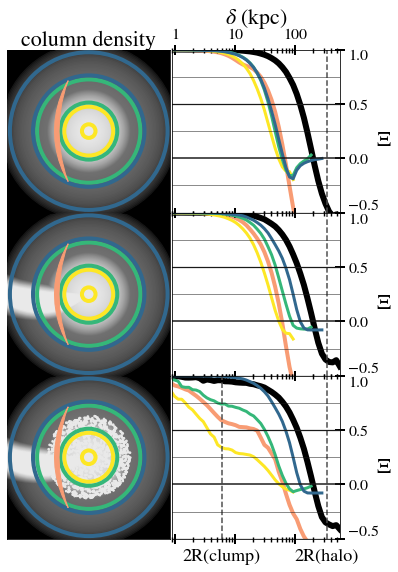

In [48]:
%matplotlib inline

fig = plt.figure( figsize=(3*ncols, 3*nrows), facecolor='w' )
ax = plt.gca()

gs = gridspec.GridSpec( nrows, ncols )
gs.update( wspace=0.0001, hspace=0.0001 )

for i, ip in enumerate( ips ):
    
    # Plot the idealized image
    ax = plt.subplot( gs[i,0], )
    ip.plot_idealized_projection(
        ax,
        cmap = plt.get_cmap( 'Greys_r' ),
    )
    
    # Circles for annuli
    for k in range( len( annuli ) - 1 ):
        shift = 5.
        for r in [ annuli[k] + shift, annuli[k+1] - shift*2 ]:
            cir = plt.Circle(
                (0,0),
                radius=r,
                edgecolor=colors[k],
                facecolor='none',
                linewidth = 4,
            )
            cir.set_zorder( 1000 )
            ax.add_patch( cir )
    
    # Fiducial
    ax = plt.subplot( gs[i,1], )
        
    # TPCFs
    tpcf = all_tpcfs[( 'PS', 'W', )][i]
    ax.plot(
        xs_log,
        tpcf,
        linewidth = 6,
        color = 'k',
        label = label_or_not( 'no radial normalization', ax.is_first_col() ),
        zorder = -1,
    )
     
    # Annuli
    tpcfs = all_tpcfs[( 'A', 'PS', 'W', )][i]
    for k, tpcf in enumerate( tpcfs ):
        
        do_plot = xs_log < annuli[k+1]
        
        ax.plot(
            xs_log[do_plot],
            tpcf[do_plot],
            linewidth = 3,
            color = colors[k],
        )
    ax.set_ylim( -0.5, 1. )
    
    # Arc TPCF
    tpcf = all_tpcfs[( 'arc', 'W', )][i]
    # Don't plot for scales larger than the arc
    do_plot = xs_log < np.linalg.norm( p1 - p2 )/2.
    ax.plot(
        xs_log[do_plot],
        tpcf[do_plot],
        linewidth = 4,
        color = arc_color,
        label = label_or_not( 'arc', ax.is_first_col() ),
        zorder = -1,
    )
    
# Go back through and fix up axes
for i in range( ncols ):
    for j in range( nrows ):
        
        ax = plt.subplot( gs[j,i], )
        
        # Projection Plot options
        if i < 1:
            
            ax.set_aspect( 'equal' )
            ax.tick_params( labelleft=False, labelbottom=False, left=False, bottom=False)
            
            if ax.is_first_row():
                ax.set_xlabel( 'column density', fontsize=22 )
                ax.xaxis.set_label_position( 'top' )
                
            patch = descartes.PolygonPatch(
                curve,
                fc = arc_color,
                ec = arc_color,
                zorder = 10000,
            )
            ax.add_patch( patch )
            
        # Statistics options
        if i >= 1:
            
            # Length scales
            for key, item in all_length_scales[j].items():
                if key == 'annuli':
                    continue
                    
                ax.axvline(
                    2.*item,
                    linewidth = 1.5,
                    color = '.3',
                    linestyle = '--',
                )
                
                if ax.is_last_row():
                    trans = matplotlib.transforms.blended_transform_factory( ax.transData, ax.transAxes )
                    ax.annotate(
                        s = '2R({})'.format( key ),
                        xy = ( 2.*item, 0 ),
                        xytext = ( 0, -10 ),
                        xycoords = trans,
                        textcoords = 'offset points',
                        va = 'top',
                        ha = 'center',
                        fontsize = 18,
                    )
            
            # Horizontal lines
            for y in np.arange( -1., 1., 0.25 ):
                if np.isclose( y, np.array([ -1., 0., 1. ]) ).sum() != 0:
                    linewidth = 1.5
                elif np.isclose( y, np.array([ -0.5, 0.5, ]) ).sum() != 0:
                    linewidth = 1.25
                else:
                    linewidth = 0.5
                ax.axhline(
                    y,
                    color = '0.1',
                    linewidth = linewidth,
                )
            
            # Remove tick labels
            ax.tick_params( labelleft=False, left=False, labelright=True, right=True, top=True, labelbottom=False, direction='inout' )
            if ax.is_first_row():
                ax.tick_params( labeltop=True, )
            ax.tick_params( which='minor', direction='inout', bottom=True, top=True, )
            
            # Avosid overlapping labels
            ax.get_yticklabels()[0].set_verticalalignment( 'bottom' )
            ax.get_yticklabels()[-1].set_verticalalignment( 'top' )
            
            # Axis tweaks
            ax.set_xlim( 0.9, xs_log[-1] )
            ax.set_xscale( 'log' )
            
            # Make sure enough ticks show up
            locmaj = matplotlib.ticker.LogLocator( base=10, numticks=12 ) 
            ax.xaxis.set_major_locator( locmaj )
            locmin = matplotlib.ticker.LogLocator( base=10.0, subs=np.arange( 0.1, 1., 0.1), numticks=12 )
            ax.xaxis.set_minor_locator( locmin )
            ax.xaxis.set_minor_formatter( matplotlib.ticker.NullFormatter() )
            
            # Format more nicely
            replacements = {
                1.: '1',
                10.: '10',
                100.: '100',
            }
            new_labels = []
            for ii, old_label in enumerate( ax.get_xticklabels() ):
                label = old_label
                for val, s in replacements.items():
                    if np.isclose( ax.get_xticks()[ii], val ):
                        label = s
                        break            
                new_labels.append( label )
            ax.set_xticklabels( new_labels )

            if ax.is_first_row():
                ax.set_xlabel( r'$\delta$ (kpc)', fontsize=22 )
                ax.xaxis.set_label_position( 'top' )
            ax.set_ylabel( r'$\Xi$', fontsize=22, rotation=0 )
            ax.yaxis.set_label_position( 'right' )
            
#             # Legend
#             if ax.is_first_col():
#                 ax.legend(
#                     bbox_to_anchor = (0.0, 2.02, 5., 0.5 ),
#                     loc = 'lower left',
#                     ncol = 4,
#                     mode = "expand",
#                     borderaxespad = 0.,
#                     prop = {'size': 16},
#                 )

# lgd = fig.legend(
# #     bbox_to_anchor = (0.1, 0.87, 0.7, 1.0 ),
#     loc = 'lower left',
#     ncol = 4,
#     mode = "expand",
#     borderaxespad = 0.,
#     prop = {'size': 16},
# )

fig.savefig('./weighted_correlations.pdf', bbox_inches='tight')